# Feed-forward сети

Будем практиковаться на датасете:
https://www.kaggle.com/c/avito-demand-prediction

Ваша задача:
1. Создать Dataset для загрузки данных (используем только числовые данные)
2. Обернуть его в Dataloader
3. Написать архитектуру сети, которая предсказывает число показов на основании числовых данных (вы всегда можете нагенерить дополнительных факторов). Сеть должна включать BatchNorm слои и Dropout (или НЕ включать, но нужно обосновать)
4. Учить будем на функцию потерь с кагла (log RMSE) - нужно её реализовать
5. Сравните сходимость Adam, RMSProp и SGD, сделайте вывод по качеству работы модели

train-test разделение нужно сделать с помощью sklearn random_state=13, test_size = 0.25

In [ ]:
# Run this cell and select the kaggle.json file downloaded
# from the Kaggle account settings page.
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sergeylazarevich","key":"859c9f7c80ea53aad29828f931d9c2e4"}'}

In [ ]:
# Let's make sure the kaggle.json file is present.
!ls -lha kaggle.json

-rw-r--r-- 1 root root 72 Jul  1 05:49 kaggle.json


In [ ]:
# Next, install the Kaggle API client.
!pip install -q kaggle

In [ ]:
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# List available datasets.
#!kaggle competitions list -s health
#!kaggle datasets list
#!kaggle competitions list --category gettingStarted

In [ ]:
# Copy the stackoverflow data set locally.
!kaggle competitions download avito-demand-prediction -f train.csv

100% 317M/318M [00:03<00:00, 123MB/s]
100% 318M/318M [00:03<00:00, 103MB/s]


In [ ]:
!unzip train.csv.zip

Archive:  train.csv.zip
  inflating: train.csv               


In [ ]:
import pandas as pd
import numpy as np

### 1. Создать Dataset для загрузки данных (используем только числовые данные)

In [ ]:
dataset = pd.read_csv('train.csv')
dataset.head()

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,description,price,item_seq_number,activation_date,user_type,image,image_top_1,deal_probability
0,b912c3c6a6ad,e00f8ff2eaf9,Свердловская область,Екатеринбург,Личные вещи,Товары для детей и игрушки,Постельные принадлежности,NaN,NaN,Кокоби(кокон для сна),"Кокон для сна малыша,пользовались меньше месяц...",400.0,2,2017-03-28,Private,d10c7e016e03247a3bf2d13348fe959fe6f436c1caf64c...,1008.0,0.12789
1,2dac0150717d,39aeb48f0017,Самарская область,Самара,Для дома и дачи,Мебель и интерьер,Другое,NaN,NaN,Стойка для Одежды,"Стойка для одежды, под вешалки. С бутика.",3000.0,19,2017-03-26,Private,79c9392cc51a9c81c6eb91eceb8e552171db39d7142700...,692.0,0.00000
2,ba83aefab5dc,91e2f88dd6e3,Ростовская область,Ростов-на-Дону,Бытовая электроника,Аудио и видео,"Видео, DVD и Blu-ray плееры",NaN,NaN,Philips bluray,"В хорошем состоянии, домашний кинотеатр с blu ...",4000.0,9,2017-03-20,Private,b7f250ee3f39e1fedd77c141f273703f4a9be59db4b48a...,3032.0,0.43177
3,02996f1dd2ea,bf5cccea572d,Татарстан,Набережные Челны,Личные вещи,Товары для детей и игрушки,Автомобильные кресла,NaN,NaN,Автокресло,Продам кресло от0-25кг,2200.0,286,2017-03-25,Company,e6ef97e0725637ea84e3d203e82dadb43ed3cc0a1c8413...,796.0,0.80323
4,7c90be56d2ab,ef50846afc0b,Волгоградская область,Волгоград,Транспорт,Автомобили,С пробегом,ВАЗ (LADA),2110,"ВАЗ 2110, 2003",Все вопросы по телефону.,40000.0,3,2017-03-16,Private,54a687a3a0fc1d68aed99bdaaf551c5c70b761b16fd0a2...,2264.0,0.20797


In [ ]:
# Уменьшим размерность для ускорения работы
#dataset = dataset.iloc[:120000]

### 2. Обернуть его в Dataloader

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import torch.nn as nn
from torch import optim

from tqdm import tqdm
import re

import torch

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
def text_preprocession(text):
    text = str(text)
    text = text.lower()
    clean = re.sub(r"[,.;@#?!&$]+\ *", " ", text)
    return clean

In [ ]:
df = pd.DataFrame()
categorial_features = ['user_type','region',
                                'city','parent_category_name','category_name',
                                'param_1','param_2','param_3','description','title']

for col in categorial_features:
    lbl = LabelEncoder()
    df[col] = lbl.fit_transform(dataset[col].fillna('N/A').astype(str).apply(text_preprocession))


number_features = ['price', 'item_seq_number', 'image_top_1', 'deal_probability']

for col in number_features:
    df[col] = dataset[col].fillna(0)

train-test разделение нужно сделать с помощью sklearn random_state=13, test_size = 0.25

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('deal_probability', axis=1), 
                                                    df.deal_probability.values, 
                                                    test_size=0.25, 
                                                    random_state=13)

In [ ]:
class RangeDataset(torch.utils.data.Dataset):
    def __init__(self, df, lebel):
        self.df = df
        self.lebel = lebel

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
       return torch.tensor(self.df.iloc[index], dtype=torch.float32), \
              torch.tensor([self.lebel[index]], dtype=torch.float32)

In [ ]:
train = RangeDataset(X_train, y_train)
test = RangeDataset(X_test, y_test)

In [ ]:
len(train), len(test)

(1127568, 375856)

In [ ]:
train_loader =  torch.utils.data.DataLoader(dataset=train,
                                           batch_size=64, 
                                           shuffle=True,
                                           num_workers=0)
test_loader =  torch.utils.data.DataLoader(dataset=test,
                                           batch_size=8, 
                                           shuffle=True,
                                           num_workers=0)

### 3. Написать архитектуру сети, которая предсказывает число показов на основании числовых данных (вы всегда можете нагенерить дополнительных факторов). Сеть должна включать BatchNorm слои и Dropout (или НЕ включать, но нужно обосновать)

In [ ]:
class Perceptron(nn.Module):
    def __init__(self, input_dim, output_dim, activation="relu"):
        super(Perceptron, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim)
        self.activation = activation
        
    def forward(self, x):
        x = self.fc(x)
        if self.activation=="relu":
            LeakyReLU = nn.LeakyReLU(0.01)
            return LeakyReLU(x)
        if self.activation=="sigmoid":
            Sigmoid = nn.Sigmoid()
            return Sigmoid(x)
        raise RuntimeError
        

class FeedForward(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FeedForward, self).__init__()
        self.bn1 = nn.BatchNorm1d(input_dim)
        self.fc1 = Perceptron(input_dim, 10 * hidden_dim)
        self.bn2 = nn.BatchNorm1d(10 * hidden_dim)
        self.fc2 = Perceptron(10 * hidden_dim, hidden_dim)
        self.bn3 = nn.BatchNorm1d(hidden_dim)
        self.dp = nn.Dropout(0.25)
        self.fc3 = Perceptron(hidden_dim, output_dim, "sigmoid")
        
    def forward(self, x):
        x = self.bn1(x)
        x = self.fc1(x)
        x = self.bn2(x)
        x = self.fc2(x)
        x = self.dp(x)
        x = self.fc3(x)
        return x

### 4. Учить будем на функцию потерь с кагла (log RMSE) - нужно её реализовать

In [ ]:
class RMSLELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self, pred, actual):
        return torch.sqrt(self.mse(torch.log(pred + 1), torch.log(actual + 1)))

In [ ]:
model = FeedForward(13, 10, 1)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = RMSLELoss()
#criterion = nn.MSELoss()
model.to(device)

FeedForward(
  (bn1): BatchNorm1d(13, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Perceptron(
    (fc): Linear(in_features=13, out_features=100, bias=True)
  )
  (bn2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Perceptron(
    (fc): Linear(in_features=100, out_features=10, bias=True)
  )
  (bn3): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp): Dropout(p=0.25, inplace=False)
  (fc3): Perceptron(
    (fc): Linear(in_features=10, out_features=1, bias=True)
  )
)

In [ ]:
model.train()
epochs = 5
for epoch in tqdm(range(epochs)):  
    running_loss = 0.0
    for i, data in enumerate(train_loader, 1):
        inputs, labels = data[0].to(device), data[1].to(device)

        # обнуляем градиент
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # выводим статистику о процессе обучения
        running_loss += loss.item()

        n = 2000  # печатаем каждые 2000 mini-batches
        if i % n == 0:    
            if i == n:
                print(f'\n[{epoch + 1}, {i}] loss: {(running_loss / (i)):.3f}')
            else:
                print(f'[{epoch + 1}, {i}] loss: {(running_loss / (i)):.3f}')

  0%|          | 0/5 [00:00<?, ?it/s]


[1, 2000] loss: 0.189
[1, 4000] loss: 0.185
[1, 6000] loss: 0.183
[1, 8000] loss: 0.182
[1, 10000] loss: 0.181
[1, 12000] loss: 0.180
[1, 14000] loss: 0.180
[1, 16000] loss: 0.180


 20%|██        | 1/5 [03:28<13:54, 208.70s/it]


[2, 2000] loss: 0.177
[2, 4000] loss: 0.177
[2, 6000] loss: 0.177
[2, 8000] loss: 0.177
[2, 10000] loss: 0.177
[2, 12000] loss: 0.177
[2, 14000] loss: 0.177
[2, 16000] loss: 0.177


 40%|████      | 2/5 [07:13<10:53, 217.99s/it]


[3, 2000] loss: 0.177
[3, 4000] loss: 0.176
[3, 6000] loss: 0.176
[3, 8000] loss: 0.176
[3, 10000] loss: 0.176
[3, 12000] loss: 0.176
[3, 14000] loss: 0.176
[3, 16000] loss: 0.176


 60%|██████    | 3/5 [10:40<07:06, 213.06s/it]


[4, 2000] loss: 0.177
[4, 4000] loss: 0.176
[4, 6000] loss: 0.176
[4, 8000] loss: 0.176
[4, 10000] loss: 0.176
[4, 12000] loss: 0.176
[4, 14000] loss: 0.176
[4, 16000] loss: 0.176


 80%|████████  | 4/5 [14:31<03:40, 220.13s/it]


[5, 2000] loss: 0.176
[5, 4000] loss: 0.176
[5, 6000] loss: 0.176
[5, 8000] loss: 0.176
[5, 10000] loss: 0.176
[5, 12000] loss: 0.176
[5, 14000] loss: 0.176
[5, 16000] loss: 0.176


100%|██████████| 5/5 [18:32<00:00, 222.49s/it]


In [ ]:
model.eval()
running_loss = 0
j = 0
for data in test_loader:
    inputs, labels = data[0].to(device), data[1].to(device)
    
    outputs = model(inputs)
    loss = criterion(outputs, labels)

    # выводим статистику о процессе обучения
    running_loss += loss.item()
    j += 1

print(f'Test loss after Training = {running_loss / j:.3f}')

Test loss after Training = 0.165


### 5. Сравните сходимость Adam, RMSProp и SGD, сделайте вывод по качеству работы модели

In [ ]:
def tain(train_loader, model, criterion, optimizer, device, epochs=5, n = 200):
    array_loss = []
    model.train()
    
    for epoch in tqdm(range(epochs)):  
        running_loss = 0.0
        array_loss_batches = []
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)

            # обнуляем градиент
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # выводим статистику о процессе обучения
            running_loss += loss.item()

            # печатаем каждые n mini-batches
            if i % n == 0:
                array_loss_batches.append(running_loss / (i+1))    
                
        array_loss.extend(array_loss_batches)
    
    return array_loss

In [ ]:
#Adam, RMSProp и SGD

criterion = RMSLELoss()

model_Adam = FeedForward(13, 10, 1)
model_Adam.to(device)
optimizer_Adam = optim.Adam(model_Adam.parameters(), lr=0.001)
array_loss_Adam = tain(train_loader, model_Adam, criterion, optimizer_Adam, device)

model_SGD = FeedForward(13, 10, 1)
model_SGD.to(device)
optimizer_SGD = torch.optim.SGD(model_SGD.parameters(), lr=0.1, momentum=0.9)
array_loss_SGD = tain(train_loader, model_SGD, criterion, optimizer_SGD, device)

model_RMSprop = FeedForward(13, 10, 1)
model_RMSprop.to(device)
optimizer_RMSprop = torch.optim.RMSprop(model_RMSprop.parameters(), lr=0.01, momentum=0.9)
array_loss_RMSprop= tain(train_loader, model_RMSprop, criterion, optimizer_RMSprop, device)


100%|██████████| 5/5 [15:52<00:00, 190.57s/it]


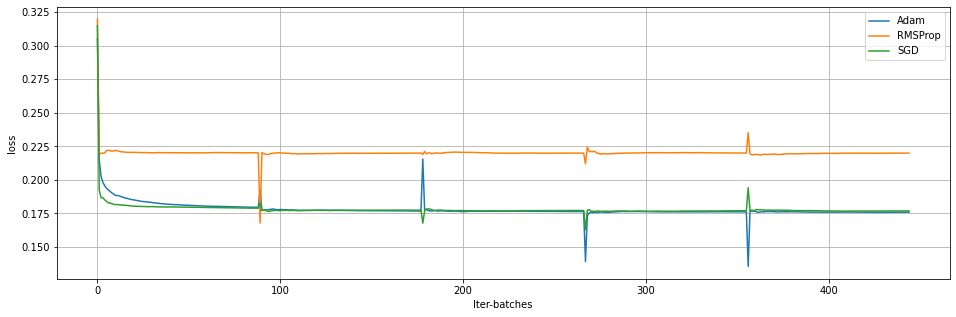

In [ ]:
import matplotlib.pyplot as plt
# черчение диаграммы точности в зависимости от оптимизатора
plt.figure(figsize = (16,5))
plt.plot(array_loss_Adam, label = 'Adam')
plt.plot(array_loss_RMSprop, label = 'RMSProp')
plt.plot(array_loss_SGD, label = 'SGD')
plt.xlabel('Iter-batches')
plt.ylabel('loss')
plt.grid()
plt.legend()
plt.show()

**Вывод: _Лучшие результаты работы показали оптимизаторы  Adam и SGD, немного хуже RMSProp. Пики на графике говорят нам про наличие в нейросети  слоя Dropout() который выключает из вычислений излишне переобученные нейроны._**